# Product Recognition of Food Products
 Image Processing and Computer Vision project
 
Habib Kazemi  0001119071 [habib.kazemi2@studio.unibo.it]

Safoura Banihashemi 0001109509 [safoura.banihashemi@studio.unibo.it]

Hesam Sheikh Hassani 0001111590 [hesam.sheikhhassani@studio.unibo.it]


 



## Track A - Single Instance Detection
To solve this track, we used a combination of `SIFT` and `Template Match`. We used `SIFT` to detect the keypoints and calculate the descriptions of the reference and scene images. We used brute force to match the keypoints and used `Ransac` to remove the outliers. As some images didn't have enough keypoint matches, we used `Template Match` to validate the found instances. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

## Import Libraries

In [15]:
# Import library
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

## Loading reference and scene images

In [16]:
def load_images_from_directory(directory, file_name_list):
    """
    Load images from a directory and store them in a dictionary.

    Args:
        directory (str): The directory path where the images are located.
        file_name_list (list): A list of file names of the images to be loaded.

    Returns:
        dict: A dictionary where the keys are the file names and the values are the loaded images.

    """
    images = {}
    for file_name in file_name_list:
        image_path = os.path.join(directory, file_name)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images[file_name] = image
    return images


In [17]:
models_dir = "dataset/models"
scenes_dir = "dataset/scenes"

trackA_scene_images_file_names = [f'scene{i}.png' for i in range(1, 6)]
trackA_reference_images_file_names = [f'ref{i}.png' for i in range(1, 15)]

trackA_scene_images = load_images_from_directory(scenes_dir, trackA_scene_images_file_names)
trackA_reference_images = load_images_from_directory(models_dir, trackA_reference_images_file_names)

print(trackA_scene_images.keys())
print(trackA_reference_images.keys())

dict_keys(['scene1.png', 'scene2.png', 'scene3.png', 'scene4.png', 'scene5.png'])
dict_keys(['ref1.png', 'ref2.png', 'ref3.png', 'ref4.png', 'ref5.png', 'ref6.png', 'ref7.png', 'ref8.png', 'ref9.png', 'ref10.png', 'ref11.png', 'ref12.png', 'ref13.png', 'ref14.png'])


## Denoise images
Images have heavy noise and need to denoise them before extracting features.

In [18]:
def denoise_image(img):
    """
    Applies denoising to the input image.

    Parameters:
    img (numpy.ndarray): The input image to be denoised.

    Returns:
    numpy.ndarray: The denoised image.
    """
    median_blurred = cv2.medianBlur(img, 5)
    return cv2.bilateralFilter(median_blurred, 9, 75, 75)

In [19]:
trackA_denoised_scene_images = {}
for filename, image in trackA_scene_images.items():
    trackA_denoised_scene_images[filename] = denoise_image(image) 

## Keypoint detection and description
We used SIFT (Scale-Invariant Feature Transform) to detect keypoints and extract descriptions from the images. To match these descriptions, we employed a brute-force matcher.

In [20]:
def extract_features_sift(image):
    """
    Extracts SIFT features from the given image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    keypoints (list): List of keypoints detected in the image.
    descriptions (numpy.ndarray): Array of descriptions computed for each keypoint.
    """
    sift = cv2.SIFT_create()
    keypoints, descriptions = sift.detectAndCompute(image, None)
    return keypoints, descriptions

In [21]:
def match_descriptions(ref_descriptions, scene_descriptions, ratio=0.75):
    """
    Matches the reference descriptions with the scene descriptions.
    It applys lowe's ratio test to filter the good matches.

    Parameters:
    ref_descriptions (list): List of reference descriptions.
    scene_descriptions (list): List of scene descriptions.
    ratio (float): Ratio threshold for the ratio test. Default is 0.75.

    Returns:
    list: List of good matches.

    """
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(ref_descriptions, scene_descriptions, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio * n.distance]
    return good_matches


## Helper functions to visualize keypoints and matches
Visualizing the results is crucial for understanding the project and debugging the code effectively. For instance, by visualizing the outputs, we discovered that some images had a low number of matches. This indicated that using SIFT alone was insufficient to detect the object in the scene image. To address this issue, we decided to combine SIFT with another method—template matching.

In [22]:
def visualize_keypoints(ref_img, scene_img, ref_keypoints, scene_keypoints):
    """
    Visualizes the keypoints on the reference and scene images.

    Args:
        - ref_img (numpy.ndarray): The reference image.
        - scene_img (numpy.ndarray): The scene image.
        - ref_keypoints (list): List of keypoints detected in the reference image.
        - scene_keypoints (list): List of keypoints detected in the scene image.
    """
    # Draw keypoints on the reference and scene images
    ref_img_with_keypoints = cv2.drawKeypoints(ref_img, ref_keypoints, None, color=(0, 255, 0))
    scene_img_with_keypoints = cv2.drawKeypoints(scene_img, scene_keypoints, None, color=(0, 255, 0))

    # Display the images with keypoints
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Reference Image Keypoints')
    plt.imshow(cv2.cvtColor(ref_img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Scene Image Keypoints')
    plt.imshow(cv2.cvtColor(scene_img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.show()

In [23]:
def visualize_keypoints_match(good_matches, inlier_match_title, ref_img, ref_keypoints, scene_img, scene_keypoints, mask=None):
    """
    Visualizes the keypoints match between two images.

    Args:
        good_matches (list): List of good matches between keypoints.
        inlier_match_title (str): Title for the visualization.
        ref_img (numpy.ndarray): Reference image.
        ref_keypoints (list): Keypoints in the reference image.
        scene_img (numpy.ndarray): Scene image.
        scene_keypoints (list): Keypoints in the scene image.
        mask (numpy.ndarray, optional): Homography Mask to filter the matches. Defaults to None.
    """
    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       flags=2)
    if mask is not None:
        draw_params['matchesMask'] = mask.ravel().tolist()
    img3 = cv2.drawMatches(ref_img, ref_keypoints, scene_img, scene_keypoints, good_matches, None, **draw_params)
    
    plt.figure(figsize=(15, 10))
    plt.title(inlier_match_title)
    plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.show()


## Template matching
Since objects can appear in different sizes within the scene image, relying solely on template matching does not yield optimal results. Instead, we use template matching as a validation step to confirm whether the object found using `SIFT` is valid. It receives a template (our model) and an image (a cropped portion from the scene image identified using perspectiveTransform). We resized the template to the size of the given image, as the give image claims to be the exact instance that we are looking for, we can resize to its size and solve the scale invariance problem of template matching. The function returns a similarity percentage. If the similarity is above a predefined threshold; the found area is considered an instance of the reference image.

In [24]:
def template_match(template, img, debug=False):
    """
    Perform template matching on an image using a given template.

    Args:
        template (numpy.ndarray): The template image to match.
        img (numpy.ndarray): The input image to search for the template.
        debug (bool, optional): Whether to display debug information and visualization. Defaults to False.

    Returns:
        float: The best match value indicating the similarity between the template and the matched region.

    """
    method = 'TM_CCORR_NORMED'
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_h, img_w = img.shape
    if debug:
        print(f'img_h: {img_h}', f'img_w: {img_w}')
    template = cv2.resize(template, (img_w - img_w % 10, img_h - img_h % 10))
    w, h = template.shape[::-1]
    
    # Apply template Matching
    res = cv2.matchTemplate(img, template, getattr(cv2, method))
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    best_match = max_val
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    if debug:
        print(best_match)
        cv2.rectangle(img,top_left, bottom_right, (255, 0, 0), 2)
        plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(img,cmap = 'gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

        plt.show()

    return best_match

In [25]:
def crop_image(img, dst):
    """
    Crop the input image based on the given corners.

    Parameters:
    img (numpy.ndarray): The input image to be cropped.
    dst (numpy.ndarray): The corners of the region to be cropped, obtained using perspectiveTransform.

    Returns:
    numpy.ndarray: The cropped image.

    """
    x, y, w, h = cv2.boundingRect(np.int32(dst))
    return img[y:y+h, x:x+w]

In [26]:
def calculate_homography(good_matches, projection_threshold, ref_keypoints, scene_keypoints):
    """
    Calculates the homography matrix and mask.

    Args:
        good_matches (list): List of good matches between reference and scene keypoints.
        projection_threshold (float): Threshold value for RANSAC algorithm.
        ref_keypoints (list): List of reference keypoints.
        scene_keypoints (list): List of scene keypoints.

    Returns:
        tuple: A tuple containing the homography matrix (M) and the mask.

    """
    # Extract location of good matches
    src_pts = np.float32([ref_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
    # Compute Homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, projection_threshold)
    return M, mask

## Clip coordinates
Found corners in the scene images might be out of the image bounds. To address this issue, we clip the coordinates to ensure they are within the image bounds.

In [27]:
def clip_coordinates(dst, image_width, image_height):
    """
    Clips the coordinates of the given corners to ensure they are within the image boundaries.

    Parameters:
    - dst (numpy.ndarray): The destination array containing the coordinates.
    - image_width (int): The width of the image.
    - image_height (int): The height of the image.

    Returns:
    - numpy.ndarray: The clipped corners array with coordinates within the image boundaries.
    """
    clipped_dst = np.copy(dst)
    clipped_dst[:, :, 0] = np.clip(dst[:, :, 0], 0, image_width - 1)
    clipped_dst[:, :, 1] = np.clip(dst[:, :, 1], 0, image_height - 1)
    return clipped_dst

## Draw boundings and add labels
To visualize the bounding boxes, we draw rectangles around the detected instances. We also add labels to the bounding boxes to indicate the reference image that was found in the scene image.

In [28]:
def draw_bounding_box_with_label(bounding_box_title, rect_dict, img):
    """
    Draw bounding boxes with labels on an image.

    Parameters:
    - bounding_box_title (str): The title of the bounding box plot.
    - rect_dict (dict): A dictionary containing the labels as keys and a list of bounding box coordinates as values.
    - img (numpy.ndarray): The input image.

    Returns:
    None
    """

    colors = [
        [255, 0, 0],     # Red
        [0, 255, 0],     # Green
        [0, 0, 255],     # Blue
        [255, 255, 0],   # Yellow
        [255, 165, 0],   # Orange
        [0, 255, 255],   # Cyan
        [255, 0, 255],   # Magenta
        [128, 0, 128],   # Purple
        [0, 128, 0],     # Dark Green
        [128, 128, 0]    # Olive 
    ]

    for i, (label, rect_list) in enumerate(rect_dict.items()):
        for (x, y, w, h) in rect_list:
            # Draw the bounding rectangle
            cv2.rectangle(img, (x, y), (x + w, y + h), colors[i], 15)

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 2.5
            font_color = (255, 255, 255)  # white color
            thickness = 2
            text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)

            # Draw a filled rectangle behind the text
            rectangle_bgr = colors[i]
            label_x, label_y = x+20, y + h -20
            rectangle_x, rectangle_y = label_x - 5, label_y - text_size[1] - 5  # padding around text
            rectangle_w, rectangle_h = text_size[0] + 10, text_size[1] + 10  # padding around text
            cv2.rectangle(img, (rectangle_x, rectangle_y), (rectangle_x + rectangle_w, rectangle_y + rectangle_h), rectangle_bgr, -1)

            # Draw the text on top of the background rectangle
            cv2.putText(img, label, (label_x, label_y), font, font_scale, font_color, thickness, cv2.LINE_AA)

    plt.title(bounding_box_title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


## Find instances in the scene images
This function finds instances of the reference images in the scene images. First calculates the homography between the reference and scene images using the good matches and then projects the corners into the scenes using perspectiveTransform to find an area that claims to be the instance. If the number of inliers is above the threshold it has found the instance successfully and returns the rectangle x,y,w,h. But if the number of inliers is less than a predefined threshold, it uses template matching to validate if the found area is an instance we are looking for or not. If the confidence of the template matching is less than a predefined threshold, the found area is not an instance of the reference image.


In [29]:
def find_instance_in_image(ref_img, scene_img, ref_keypoints, scene_keypoints, good_matches, inlier_match_title ='Inlier Matches', projection_threshold=5.0, inlier_threshold=55, template_match_threshold=0.95, debug=False):
    """
    Finds an instance of a reference image within a scene image using the combination of SIFT feature matching and template matching.

    Args:
        ref_img (numpy.ndarray): The reference image.
        scene_img (numpy.ndarray): The scene image.
        ref_keypoints (list): List of keypoints detected in the reference image.
        scene_keypoints (list): List of keypoints detected in the scene image.
        good_matches (list): List of good matches between the keypoints in the reference and scene images.
        inlier_match_title (str, optional): Title for the visualization of inlier matches. Defaults to 'Inlier Matches'.
        projection_threshold (float, optional): Threshold for RANSAC-based homography calculation. Defaults to 5.0.
        inlier_threshold (int, optional): Minimum number of inliers required for a successful match. Defaults to 55.
        template_match_threshold (float, optional): Threshold for template matching confidence. Defaults to 0.95.
        debug (bool, optional): Flag to enable debug mode. To visualise the keypoint matches and draw bounding boxes for all possible instances. Defaults to False.

    Returns:
        tuple: A tuple containing a boolean indicating whether a match was found, and the bounding rectangle of the matched instance.
    """
    M, mask = calculate_homography(good_matches, projection_threshold, ref_keypoints, scene_keypoints)

    num_of_inliers = sum(mask.ravel())
    if debug: print("num_of_inliers: ", num_of_inliers)

    ref_h, ref_w = ref_img.shape[:2]
    # Corners of the reference image
    pts = np.float32([[0,0], [0, ref_h - 1], [ref_w - 1, ref_h - 1], [ref_w - 1, 0]]).reshape(-1, 1, 2)

    # Projecting the corners into the Scene image
    dst = cv2.perspectiveTransform(pts, M)

    # Ensure dst coordinates are within image bounds
    dst = clip_coordinates(dst, scene_img.shape[1], scene_img.shape[0])
    
    if debug:
        visualize_keypoints_match(good_matches, inlier_match_title, ref_img, ref_keypoints, scene_img, scene_keypoints, mask)

    # if number of inliers >= 55 it's match but if it is < 55 we should do template matching
    if num_of_inliers < inlier_threshold:
        cropped_img = crop_image(scene_img, dst)
        cropped_w, cropped_h = cropped_img.shape[:2]
        confidence = 0
        if cropped_w > 50 and cropped_h > 50:
            confidence = template_match(ref_img, cropped_img, debug=debug)
        elif debug:
            print("Crop size is too small", cropped_img.shape)

        if not debug and confidence < template_match_threshold:
            return False, (0,0,0,0)

    return True, cv2.boundingRect(dst)


## Extract features
We find keypoints and calculate descriptions for all reference and scene images of TrackA.

In [30]:
# Extract features for all reference and scene images of TrackA
trackA_scene_points = {}
trackA_ref_points = {}
for scene_name, scene_img in trackA_denoised_scene_images.items():
    ref_keypoints, ref_descriptions = extract_features_sift(scene_img)
    trackA_scene_points[scene_name] = {'kp':ref_keypoints, 'desc':ref_descriptions}

for ref_name, ref_img in trackA_reference_images.items():
    ref_keypoints, ref_descriptions = extract_features_sift(ref_img)
    trackA_ref_points[ref_name] = {'kp':ref_keypoints, 'desc':ref_descriptions}

## Complete the object detection

Here we complete the object detection by finding instances of the reference images within the scene images. We start by matching the descriptions of the reference and scene images. If the number of good matches exceeds a predefined threshold, we invoke the `find_instance_in_image` function. If an instance is found, we draw a bounding box around the detected instance, add a label to the bounding box, and print the position, width, and height of the detected instance.


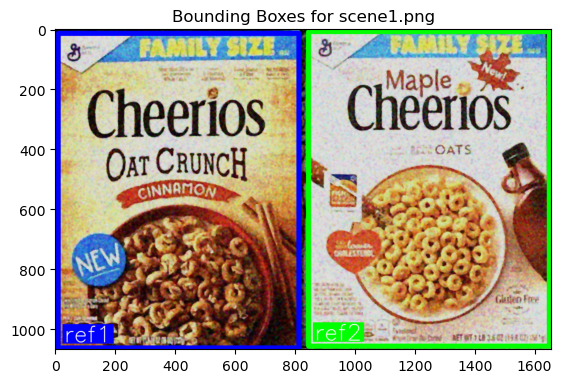

product ref1 - 1 instance found: 
	Instance 1 {position: (412, 539), width: 804px, height: 1050px}
product ref2 - 1 instance found: 
	Instance 1 {position: (1248, 533), width: 804px, height: 1050px}


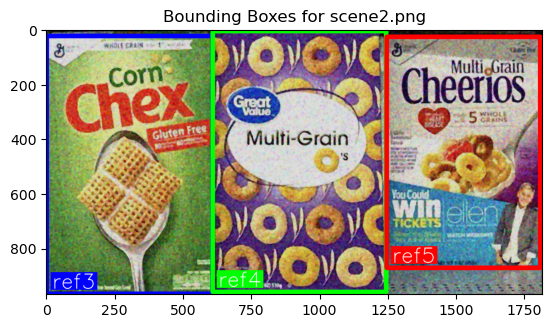

product ref3 - 1 instance found: 
	Instance 1 {position: (305, 496), width: 607px, height: 942px}
product ref4 - 1 instance found: 
	Instance 1 {position: (927, 483), width: 635px, height: 953px}
product ref5 - 1 instance found: 
	Instance 1 {position: (1528, 450), width: 562px, height: 844px}


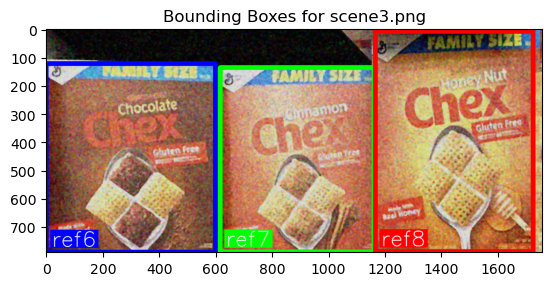

product ref6 - 1 instance found: 
	Instance 1 {position: (300, 456), width: 600px, height: 668px}
product ref7 - 1 instance found: 
	Instance 1 {position: (889, 462), width: 545px, height: 653px}
product ref8 - 1 instance found: 
	Instance 1 {position: (1446, 398), width: 559px, height: 780px}


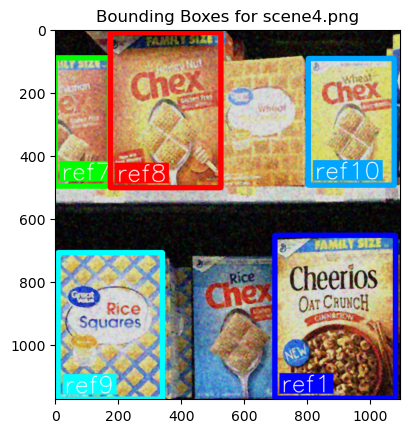

product ref1 - 1 instance found: 
	Instance 1 {position: (887, 912), width: 382px, height: 517px}
product ref7 - 1 instance found: 
	Instance 1 {position: (86, 294), width: 172px, height: 407px}
product ref8 - 1 instance found: 
	Instance 1 {position: (350, 257), width: 350px, height: 492px}
product ref9 - 1 instance found: 
	Instance 1 {position: (174, 941), width: 331px, height: 465px}
product ref10 - 1 instance found: 
	Instance 1 {position: (938, 294), width: 272px, height: 402px}


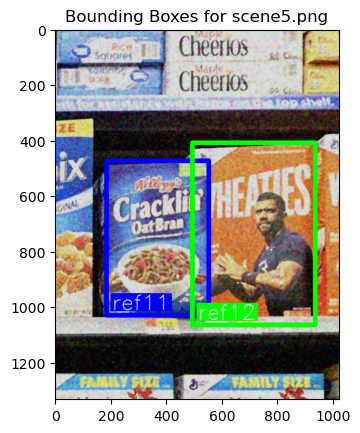

product ref11 - 1 instance found: 
	Instance 1 {position: (369, 752), width: 368px, height: 556px}
product ref12 - 1 instance found: 
	Instance 1 {position: (715, 737), width: 442px, height: 656px}


In [31]:
min_match_count = 20
debug = False
found_items = {}
for scene_name, scene_data in trackA_scene_points.items():
    found_items[scene_name] = {}
    for ref_name, ref_data in trackA_ref_points.items():
        good_matches = match_descriptions(ref_data['desc'], scene_data['desc'])
        if debug:
            print(f"Number of good matches between {ref_name} and {scene_name}: {len(good_matches)}")
        if len(good_matches) > min_match_count:
            found, bounding_rect = find_instance_in_image(trackA_reference_images[ref_name], trackA_denoised_scene_images[scene_name], ref_data['kp'], scene_data['kp'], good_matches, inlier_match_title=f'Inlier Matches Between {ref_name} and {scene_name}', debug=debug)
            if found:
                if ref_name in found_items[scene_name]:
                    found_items[scene_name][ref_name.replace(".png", "")].append(bounding_rect)
                else:
                    found_items[scene_name][ref_name.replace(".png", "")] = [bounding_rect]

    draw_bounding_box_with_label(f'Bounding Boxes for {scene_name}', found_items[scene_name], trackA_denoised_scene_images[scene_name].copy())
    for (ref_name, rect_list) in found_items[scene_name].items():
        print(f"product {ref_name} - {len(found_items[scene_name][ref_name])} instance found: ")
        for i, (x, y, w, h) in enumerate(rect_list):
            print(f"\tInstance {i+1} {{position: ({x + w // 2}, {y + h // 2}), width: {w}px, height: {h}px}}")
            
            